In [1]:
from dataretrieval import nwis
import geopandas as gpd
from pathlib import Path

In [2]:
fn = Path('../../data/basin_shapefile/gunnison_boundary/gunnison_boundary.shp')
gdf = gpd.read_file(fn)

gdf.bounds.values[0]

array([-107.6875,   37.875 , -106.25  ,   39.0625])

In [3]:
startDt = '2010-01-01'
endDt = '2023-02-01'

# siteListPhos = nwis.what_sites(stateCd="CO", parameterCd="00665")
siteListPhos = nwis.what_sites(bBox=list(gdf.bounds.values[0].round(4)), startDt=startDt, endDt=endDt, parameterCd='00060', )

In [4]:
filtered_sites = siteListPhos[0]
filtered_sites.head()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd
0,USGS,09107000,"TAYLOR RIVER AT TAYLOR PARK, CO.",ST,38.860271,-106.566697,S,NAD83,9340.00,10.0,NGVD29,14020001
1,USGS,09107500,"TEXAS CREEK AT TAYLOR PARK, CO",ST,38.846944,-106.554639,5,NAD83,9380.00,10.0,NGVD29,14020001
2,USGS,09108250,"WILLOW CREEK ABOVE TAYLOR PARK RESERVOIR, CO.",ST,38.817936,-106.560750,F,NAD83,9368.00,1.6,NAVD88,14020001
3,USGS,09109000,"TAYLOR RIVER BELOW TAYLOR PARK RESERVOIR, CO.",ST,38.818327,-106.609198,F,NAD83,9169.67,15.0,NGVD29,14020001
4,USGS,09110000,"TAYLOR RIVER AT ALMONT, CO.",ST,38.664437,-106.845317,F,NAD83,8010.76,15.0,NGVD29,14020001


In [5]:
filtered_sites = gpd.GeoDataFrame(filtered_sites, geometry=gpd.points_from_xy(filtered_sites['dec_long_va'], filtered_sites['dec_lat_va']), crs='epsg:4326')
sites_within_basin = filtered_sites[filtered_sites.within(gdf.geometry[0])]

In [13]:
Path('../../data/usgs_gage_locations').mkdir(exist_ok=True)
sites_within_basin.to_csv(Path('../../data/usgs_gage_locations/usgs_gages.csv'), index=False)

<GeoAxesSubplot:>

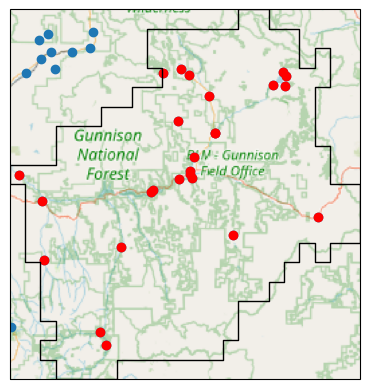

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import warnings
warnings.filterwarnings('ignore')

f, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

request = cimgt.OSM()
extent = gdf.bounds[['minx', 'maxx', 'miny', 'maxy']].values[0]
ax.set_extent(extent)
ax.add_image(request, 8)

filtered_sites.plot(ax=ax)
sites_within_basin.plot(ax=ax, color='red')
gdf.plot(ax=ax, fc='none', label='Gunnison basin boundary')

# Download the data of filtered sites

In [7]:
sites_within_basin.head()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,geometry
0,USGS,09107000,"TAYLOR RIVER AT TAYLOR PARK, CO.",ST,38.860271,-106.566697,S,NAD83,9340.00,10.0,NGVD29,14020001,POINT (-106.56670 38.86027)
1,USGS,09107500,"TEXAS CREEK AT TAYLOR PARK, CO",ST,38.846944,-106.554639,5,NAD83,9380.00,10.0,NGVD29,14020001,POINT (-106.55464 38.84694)
2,USGS,09108250,"WILLOW CREEK ABOVE TAYLOR PARK RESERVOIR, CO.",ST,38.817936,-106.560750,F,NAD83,9368.00,1.6,NAVD88,14020001,POINT (-106.56075 38.81794)
3,USGS,09109000,"TAYLOR RIVER BELOW TAYLOR PARK RESERVOIR, CO.",ST,38.818327,-106.609198,F,NAD83,9169.67,15.0,NGVD29,14020001,POINT (-106.60920 38.81833)
4,USGS,09110000,"TAYLOR RIVER AT ALMONT, CO.",ST,38.664437,-106.845317,F,NAD83,8010.76,15.0,NGVD29,14020001,POINT (-106.84532 38.66444)


In [8]:
siteINFO = nwis.get_dv(sites=sites_within_basin['site_no'], parameterCd="00060", start=startDt, end=endDt)
siteINFO

(                                           00060_Mean 00060_Mean_cd
 site_no         datetime                                           
 09107000        2010-01-01 00:00:00+00:00        44.3          A, e
                 2010-01-02 00:00:00+00:00        46.8          A, e
                 2010-01-03 00:00:00+00:00        45.9          A, e
                 2010-01-04 00:00:00+00:00        45.0          A, e
                 2010-01-05 00:00:00+00:00        48.3          A, e
 ...                                               ...           ...
 385106106571000 2023-01-28 00:00:00+00:00   -999999.0        P, Ice
                 2023-01-29 00:00:00+00:00   -999999.0        P, Ice
                 2023-01-30 00:00:00+00:00   -999999.0        P, Ice
                 2023-01-31 00:00:00+00:00   -999999.0        P, Ice
                 2023-02-01 00:00:00+00:00   -999999.0        P, Ice
 
 [83188 rows x 2 columns],
 <dataretrieval.utils.Metadata at 0x7fe93381c550>)

In [10]:
Path(f"../../data/usgs_insitu/").mkdir()
siteINFO[0].groupby('site_no').apply(lambda gp: gp.to_csv(Path(f"../../data/usgs_insitu/{gp.index[0][0]}.csv")))

""
